In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
# make sure .whl file is present
from my_package.sampler import sampler  

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [13]:
# DATA LOADING & PRE-PROCESSING

trainUsers= pd.read_csv("train_users.csv")
testUsers= pd.read_csv("test_users.csv")
newsDF=pd.read_csv("news_articles.csv")

print("Train users columns:",trainUsers.columns)
print("Test users columns:", testUsers.columns)
print("News columns:", newsDF.columns)

trainUsers['label'] = trainUsers['label'].astype(str).str.strip().str.title()
testUsers['label']  =testUsers['label'].astype(str).str.strip().str.title()

# removing rows with missing labels
trainUsers.dropna(subset=['label'], inplace=True)
testUsers.dropna(subset=['label'],inplace=True)

# mapping
user_map = {'User1': 0, 'User2': 1, 'User3': 2}
trainUsers['user_label'] = trainUsers['label'].map(user_map)
testUsers['user_label']=testUsers['label'].map(user_map)

# droppinh rows that still have NaN in 'user_label' (unknown user category)
trainUsers.dropna(subset=['user_label'], inplace=True)
testUsers.dropna(subset=['user_label'],inplace=True)

print("NaNs in trainUsers['user_label']:", trainUsers['user_label'].isnull().sum())
print("NaNs in testUsers['user_label']:", testUsers['user_label'].isnull().sum())

newsDF['category']= newsDF['category'].astype(str).str.strip().str.title()


news_map= {'Entertainment': 0, 'Education': 1, 'Tech': 2, 'Crime': 3}
newsDF['news_label'] =newsDF['category'].map(news_map)

# drgppinh rows that do not match the above 4 categories
newsDF.dropna(subset=['news_label'],inplace=True)

Train users columns: Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'label'], dtype='object')
Test users columns: Index(['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'label'], dtype='object')
News columns: Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')
NaNs in trainUsers['user_label']: 0
NaNs in testUsers['user_label']: 0


In [14]:
#  USER CLASSIFICATION (DECISION TREE)

X_train= trainUsers[['age','income', 'clicks', 'purchase_amount']]
y_train = trainUsers['user_label']

X_test = testUsers[['age', 'income', 'clicks','purchase_amount']]
y_test =testUsers['user_label']

clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(X_train,y_train)

y_pred =clf.predict(X_test)
acc =accuracy_score(y_test,y_pred)
print(f"\n[Classification] Decision Tree Accuracy: {acc*100:.2f}%")


[Classification] Decision Tree Accuracy: 33.05%


In [15]:
#  CONTEXTUAL BANDITS
# We have 3 contexts (0->User1,1->User2,2->User3) and 4 arms (0->Entertainment,1->Education,2->Tech,3->Crime).

contexts = [0, 1, 2]
num_arms = 4

# instantiateing the sampler with your roll number's last digits
roll_number = 11  # Example
reward_sampler = sampler(roll_number)

def get_arm_index(context, arm):
    """
    Each context c has 4 arms:
       j = c * 4 + arm
    => j in {0..11}
    """
    return context*num_arms + arm

In [16]:

# Storing ACTUAL rewards (not Q-values) for plotting

def train_epsilon_greedy(epsilon=0.1, T=10000):
    
    Q= {c: [0.0]*num_arms for c in contexts}
    N ={c: [0]*num_arms for c in contexts}

    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            if np.random.rand() < epsilon:
                arm = np.random.randint(num_arms)
            else:
                arm = np.argmax(Q[c])

            j = get_arm_index(c,arm)

            r = reward_sampler.sample(j)  

            # updating Q-values
            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm])/N[c][arm]

            # storing the actual reward for plotting
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


def train_ucb(C=1,T=10000):
    Q = {c: [0.0]*num_arms for c in contexts}
    N = {c: [0]*num_arms for c in contexts}
    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            ucb_values = []
            for arm in range(num_arms):
                if N[c][arm] == 0:
                    ucb_values.append(float('inf'))

                else:
                    bonus = C * math.sqrt(math.log(t)/N[c][arm])
                    ucb_values.append(Q[c][arm] + bonus)

            arm = np.argmax(ucb_values)

            j =get_arm_index(c, arm)
            r= reward_sampler.sample(j)

            # updating
            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm]) / N[c][arm]

            # storing actual reward
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


def train_softmax(temperature=1.0, T=10000):
    Q ={c: [0.0]*num_arms for c in contexts}
    N= {c: [0]*num_arms for c in contexts}
    actual_rewards_history = {c: [] for c in contexts}

    for c in contexts:
        for t in range(1, T+1):
            exp_vals = np.exp(np.array(Q[c])/temperature)

            probs = exp_vals / np.sum(exp_vals)
            arm = np.random.choice(num_arms, p=probs)

            j =get_arm_index(c, arm)
            r =reward_sampler.sample(j)

            N[c][arm] += 1
            Q[c][arm] += (r - Q[c][arm]) / N[c][arm]

            # stroing actual reward
            actual_rewards_history[c].append(r)

    return Q, actual_rewards_history


# training the bandit models
print("\n[Training Epsilon-Greedy with ε=0.1]")
egreedy_Q_01, egreedy_rewards_01 = train_epsilon_greedy(epsilon=0.1, T=10000)

print("[Training UCB with C=1]")
ucb_Q_1, ucb_rewards_1 = train_ucb(C=1, T=10000)

print("[Training SoftMax with T=1.0]")
softmax_Q_1, softmax_rewards_1 = train_softmax(temperature=1.0, T=10000)


def print_final_rewards_info(name, actual_rewards_history):
    
    print(f"\n[Final Reward Analysis for {name}]")
    all_rewards = []
    for c in contexts:
        c_rewards = actual_rewards_history[c]
        avg_c = np.mean(c_rewards)
        print(f" Context={c}, steps={len(c_rewards)}, average reward={avg_c:.2f}")
        all_rewards.extend(c_rewards)
    overall_avg = np.mean(all_rewards) if len(all_rewards) > 0 else 0
    print(f" Overall average reward across all contexts={overall_avg:.2f}\n")


print_final_rewards_info("Epsilon-Greedy (ε=0.1)", egreedy_rewards_01)
print_final_rewards_info("UCB (C=1)", ucb_rewards_1)
print_final_rewards_info("SoftMax (T=1.0)", softmax_rewards_1)


[Training Epsilon-Greedy with ε=0.1]
[Training UCB with C=1]
[Training SoftMax with T=1.0]

[Final Reward Analysis for Epsilon-Greedy (ε=0.1)]
 Context=0, steps=10000, average reward=7.19
 Context=1, steps=10000, average reward=4.41
 Context=2, steps=10000, average reward=5.51
 Overall average reward across all contexts=5.70


[Final Reward Analysis for UCB (C=1)]
 Context=0, steps=10000, average reward=8.00
 Context=1, steps=10000, average reward=4.99
 Context=2, steps=10000, average reward=6.00
 Overall average reward across all contexts=6.33


[Final Reward Analysis for SoftMax (T=1.0)]
 Context=0, steps=10000, average reward=7.97
 Context=1, steps=10000, average reward=4.87
 Context=2, steps=10000, average reward=5.82
 Overall average reward across all contexts=6.22



In [17]:

#  MAKING A RECOMMENDATION
def recommend_article(user_features, bandit_models, classifier, news_df):
    """
    user_features: array-like [age, income, clicks, purchase_amount]
    bandit_models: dict with keys = {'egreedy','ucb','softmax'} and values = Q dict
    classifier   : Decision Tree or other model to predict user_label
    news_df      : news DataFrame with 'news_label' for each article
    """
    col_names = ['age','income','clicks','purchase_amount']
    user_df = pd.DataFrame([user_features], columns=col_names)

    # predicting user context
    context_pred = classifier.predict(user_df)[0]  # 0..2

    cat_map = {0:'Entertainment',1:'Education',2:'Tech',3:'Crime'}
    recommendations = {}

    for policy_name, Q_dict in bandit_models.items():
        Q_vals = Q_dict[context_pred]
        best_arm = np.argmax(Q_vals)
        best_cat = cat_map[best_arm]

        # picking random article from best_cat
        matching = news_df[news_df['news_label'] == best_arm]
        if not matching.empty:
            article_row = matching.sample(1).iloc[0]
            recommendations[policy_name] = {
                'category': best_cat,
                'headline': article_row['headline'],
                'link': article_row['link']
            }
        else:
            recommendations[policy_name] = {
                'category': best_cat,
                'headline': None,
                'link': None
            }

    return recommendations


all_bandit_Q = {
    'egreedy': egreedy_Q_01,
    'ucb': ucb_Q_1,
    'softmax': softmax_Q_1
}

print("\nRecommendations for new user:")
new_user = [29, 29862, 91, 270.91]  

recs = recommend_article(new_user, all_bandit_Q, clf, news_df)
for policy, info in recs.items():
    print(f"  - {policy}: Category={info['category']}, Headline={info['headline']}")





Recommendations for new user:
  - egreedy: Category=Education, Headline=Morehouse College To Begin Taking Transgender Men Next Year
  - ucb: Category=Education, Headline=Walking The Walk For Working Families
  - softmax: Category=Education, Headline=Saying Yes!: 5 Pieces of Career Advice for Middle School Students


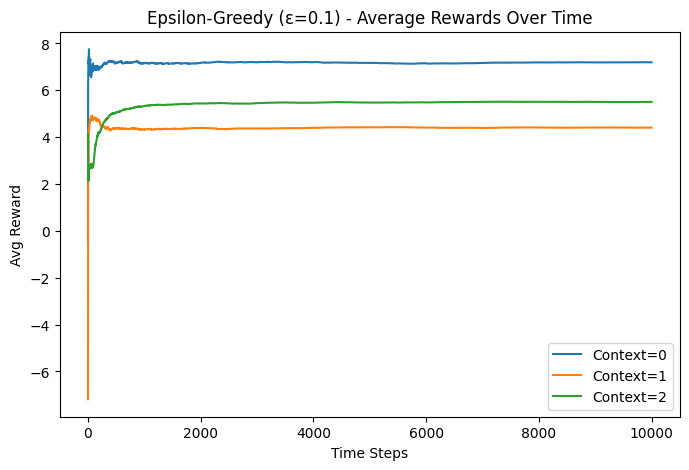

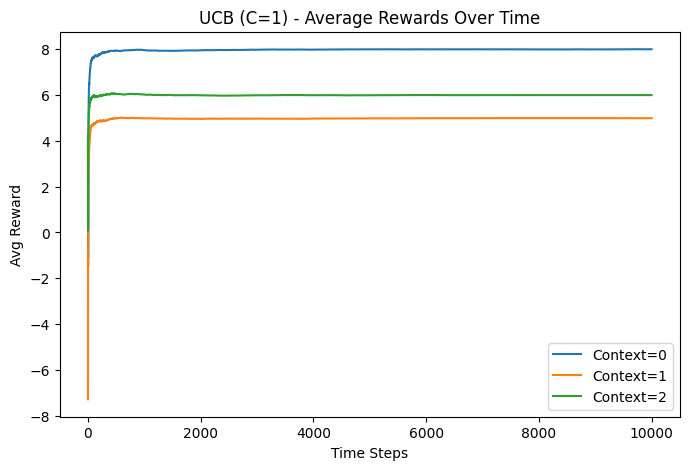

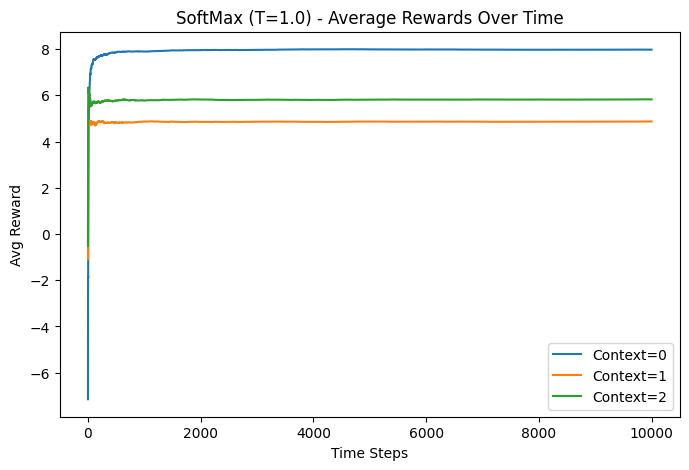

In [19]:

# EVALUATION & ANALYSIS
def plot_cumulative_rewards(actual_rewards, contexts, policy_label):
    
    plt.figure(figsize=(8,5))
    for c in contexts:
        r_array = np.array(actual_rewards[c])  # shape (T,)
        # Cumulative sum: r[1]+...+r[t]
        cumsum = np.cumsum(r_array)
        # Running average
        running_avg = cumsum / np.arange(1, len(r_array) + 1)

        plt.plot(running_avg, label=f"Context={c}")

    plt.title(f"{policy_label} - Average Rewards Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Avg Reward")
    plt.legend()
    plt.show()

plot_cumulative_rewards(egreedy_rewards_01, contexts, "Epsilon-Greedy (ε=0.1)")

plot_cumulative_rewards(ucb_rewards_1, contexts, "UCB (C=1)")

plot_cumulative_rewards(softmax_rewards_1, contexts, "SoftMax (T=1.0)")

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["User1", "User2", "User3"]))

              precision    recall  f1-score   support

       User1       0.32      0.26      0.29       672
       User2       0.34      0.51      0.41       679
       User3       0.33      0.21      0.26       649

    accuracy                           0.33      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0.33      0.33      0.32      2000




COMPARING MULTIPLE HYPERPARAMETERS WITH PRINTED EXPECTED REWARDS + PLOTS


==== Epsilon-Greedy (Hyperparam=0.1) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.199 over 10000 steps.
  Context=1: Average Actual Reward = 4.434 over 10000 steps.
  Context=2: Average Actual Reward = 5.472 over 10000 steps.
  Overall average actual reward = 5.702


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.1]
  Context=0:
    Arm=0 (Entertainment): Q = 0.952
    Arm=1 (Education): Q = 8.009
    Arm=2 (Tech): Q = -7.989
    Arm=3 (Crime): Q = -1.873
  Context=1:
    Arm=0 (Entertainment): Q = -7.000
    Arm=1 (Education): Q = 5.011
    Arm=2 (Tech): Q = 1.929
    Arm=3 (Crime): Q = -3.001
  Context=2:
    Arm=0 (Entertainment): Q = 2.934
    Arm=1 (Education): Q = -0.003
    Arm=2 (Tech): Q = -3.965
    Arm=3 (Crime): Q = 5.988



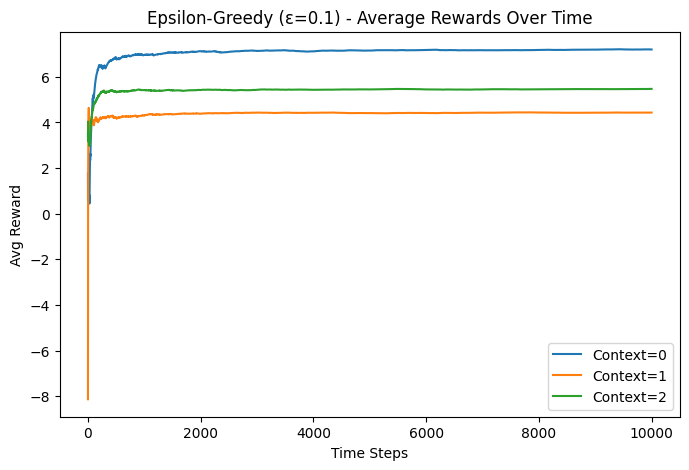


==== Epsilon-Greedy (Hyperparam=0.5) - Actual Rewards ====
  Context=0: Average Actual Reward = 3.783 over 10000 steps.
  Context=1: Average Actual Reward = 2.156 over 10000 steps.
  Context=2: Average Actual Reward = 3.665 over 10000 steps.
  Overall average actual reward = 3.201


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.5]
  Context=0:
    Arm=0 (Entertainment): Q = 0.978
    Arm=1 (Education): Q = 7.981
    Arm=2 (Tech): Q = -7.955
    Arm=3 (Crime): Q = -1.995
  Context=1:
    Arm=0 (Entertainment): Q = -6.982
    Arm=1 (Education): Q = 5.014
    Arm=2 (Tech): Q = 2.002
    Arm=3 (Crime): Q = -3.025
  Context=2:
    Arm=0 (Entertainment): Q = 3.065
    Arm=1 (Education): Q = -0.010
    Arm=2 (Tech): Q = -4.062
    Arm=3 (Crime): Q = 6.005



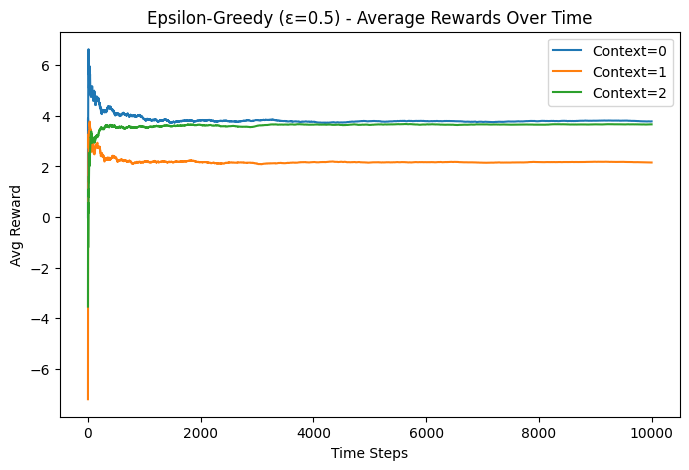


==== Epsilon-Greedy (Hyperparam=0.7) - Actual Rewards ====
  Context=0: Average Actual Reward = 2.261 over 10000 steps.
  Context=1: Average Actual Reward = 0.988 over 10000 steps.
  Context=2: Average Actual Reward = 2.688 over 10000 steps.
  Overall average actual reward = 1.979


[Final Q-Values (Expected Rewards) for Epsilon-Greedy, Hyperparam=0.7]
  Context=0:
    Arm=0 (Entertainment): Q = 0.996
    Arm=1 (Education): Q = 7.986
    Arm=2 (Tech): Q = -7.982
    Arm=3 (Crime): Q = -1.992
  Context=1:
    Arm=0 (Entertainment): Q = -6.962
    Arm=1 (Education): Q = 5.016
    Arm=2 (Tech): Q = 1.926
    Arm=3 (Crime): Q = -3.011
  Context=2:
    Arm=0 (Entertainment): Q = 2.976
    Arm=1 (Education): Q = -0.019
    Arm=2 (Tech): Q = -4.029
    Arm=3 (Crime): Q = 6.021



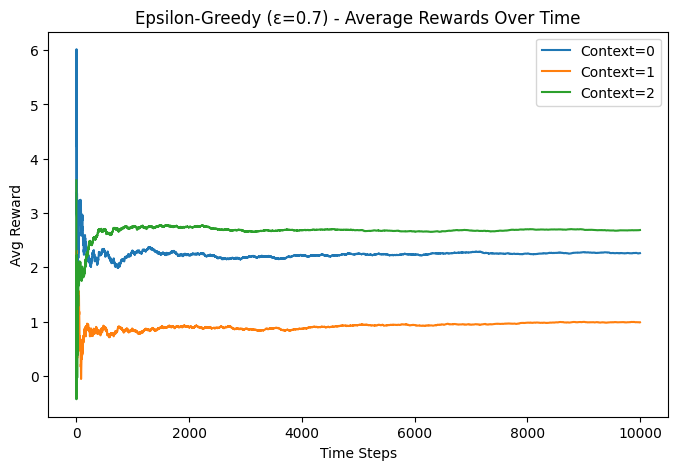


==== UCB (Hyperparam=1) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.998 over 10000 steps.
  Context=1: Average Actual Reward = 4.992 over 10000 steps.
  Context=2: Average Actual Reward = 5.983 over 10000 steps.
  Overall average actual reward = 6.324


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=1]
  Context=0:
    Arm=0 (Entertainment): Q = 0.525
    Arm=1 (Education): Q = 8.001
    Arm=2 (Tech): Q = -9.402
    Arm=3 (Crime): Q = -0.443
  Context=1:
    Arm=0 (Entertainment): Q = -7.433
    Arm=1 (Education): Q = 4.994
    Arm=2 (Tech): Q = 2.365
    Arm=3 (Crime): Q = -1.586
  Context=2:
    Arm=0 (Entertainment): Q = 3.052
    Arm=1 (Education): Q = -0.929
    Arm=2 (Tech): Q = -4.202
    Arm=3 (Crime): Q = 5.985



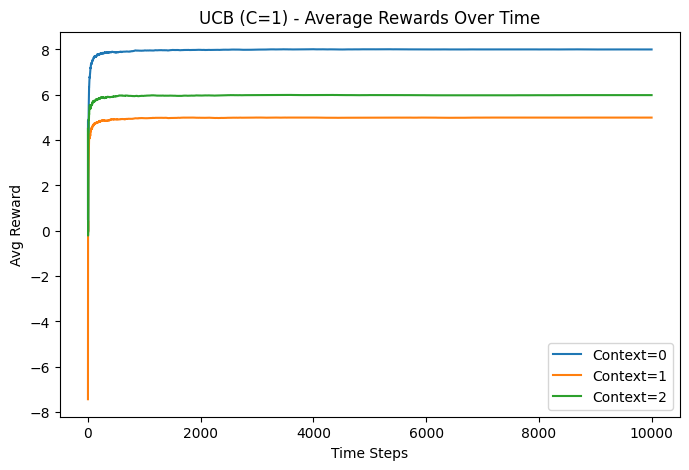


==== UCB (Hyperparam=2) - Actual Rewards ====
  Context=0: Average Actual Reward = 8.004 over 10000 steps.
  Context=1: Average Actual Reward = 4.990 over 10000 steps.
  Context=2: Average Actual Reward = 5.992 over 10000 steps.
  Overall average actual reward = 6.329


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=2]
  Context=0:
    Arm=0 (Entertainment): Q = 1.744
    Arm=1 (Education): Q = 8.007
    Arm=2 (Tech): Q = -7.843
    Arm=3 (Crime): Q = -0.589
  Context=1:
    Arm=0 (Entertainment): Q = -7.933
    Arm=1 (Education): Q = 4.993
    Arm=2 (Tech): Q = 1.463
    Arm=3 (Crime): Q = -3.230
  Context=2:
    Arm=0 (Entertainment): Q = 0.998
    Arm=1 (Education): Q = -1.814
    Arm=2 (Tech): Q = -2.579
    Arm=3 (Crime): Q = 5.995



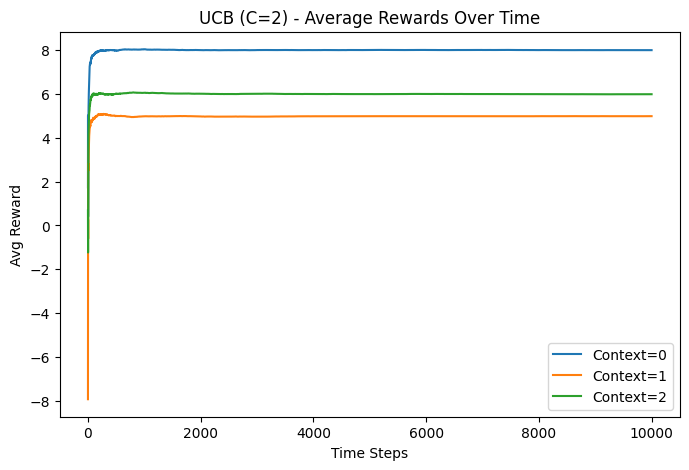


==== UCB (Hyperparam=3) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.995 over 10000 steps.
  Context=1: Average Actual Reward = 5.007 over 10000 steps.
  Context=2: Average Actual Reward = 5.989 over 10000 steps.
  Overall average actual reward = 6.331


[Final Q-Values (Expected Rewards) for UCB, Hyperparam=3]
  Context=0:
    Arm=0 (Entertainment): Q = 1.063
    Arm=1 (Education): Q = 7.999
    Arm=2 (Tech): Q = -7.290
    Arm=3 (Crime): Q = -2.017
  Context=1:
    Arm=0 (Entertainment): Q = -5.126
    Arm=1 (Education): Q = 5.013
    Arm=2 (Tech): Q = 2.005
    Arm=3 (Crime): Q = -3.415
  Context=2:
    Arm=0 (Entertainment): Q = 2.568
    Arm=1 (Education): Q = -0.502
    Arm=2 (Tech): Q = -3.677
    Arm=3 (Crime): Q = 5.994



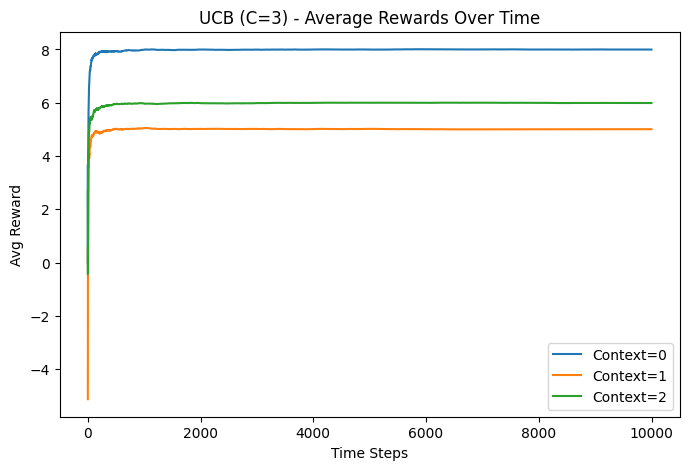


==== SoftMax (Hyperparam=0.5) - Actual Rewards ====
  Context=0: Average Actual Reward = 8.012 over 10000 steps.
  Context=1: Average Actual Reward = 5.022 over 10000 steps.
  Context=2: Average Actual Reward = 5.994 over 10000 steps.
  Overall average actual reward = 6.343


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=0.5]
  Context=0:
    Arm=0 (Entertainment): Q = 0.000
    Arm=1 (Education): Q = 8.013
    Arm=2 (Tech): Q = -6.880
    Arm=3 (Crime): Q = 0.000
  Context=1:
    Arm=0 (Entertainment): Q = 0.000
    Arm=1 (Education): Q = 5.027
    Arm=2 (Tech): Q = 2.027
    Arm=3 (Crime): Q = 0.000
  Context=2:
    Arm=0 (Entertainment): Q = 0.000
    Arm=1 (Education): Q = 0.000
    Arm=2 (Tech): Q = -5.548
    Arm=3 (Crime): Q = 5.995



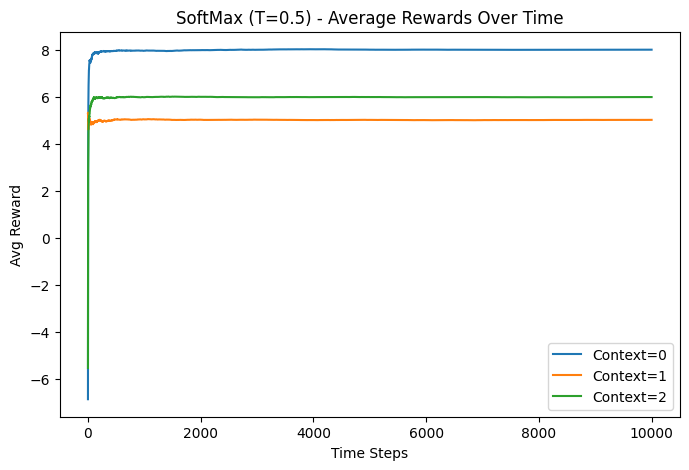


==== SoftMax (Hyperparam=1.0) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.998 over 10000 steps.
  Context=1: Average Actual Reward = 4.864 over 10000 steps.
  Context=2: Average Actual Reward = 5.817 over 10000 steps.
  Overall average actual reward = 6.226


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=1.0]
  Context=0:
    Arm=0 (Entertainment): Q = 1.206
    Arm=1 (Education): Q = 8.016
    Arm=2 (Tech): Q = -7.341
    Arm=3 (Crime): Q = -1.961
  Context=1:
    Arm=0 (Entertainment): Q = -7.364
    Arm=1 (Education): Q = 5.005
    Arm=2 (Tech): Q = 2.038
    Arm=3 (Crime): Q = -2.930
  Context=2:
    Arm=0 (Entertainment): Q = 3.006
    Arm=1 (Education): Q = 0.112
    Arm=2 (Tech): Q = -4.407
    Arm=3 (Crime): Q = 5.995



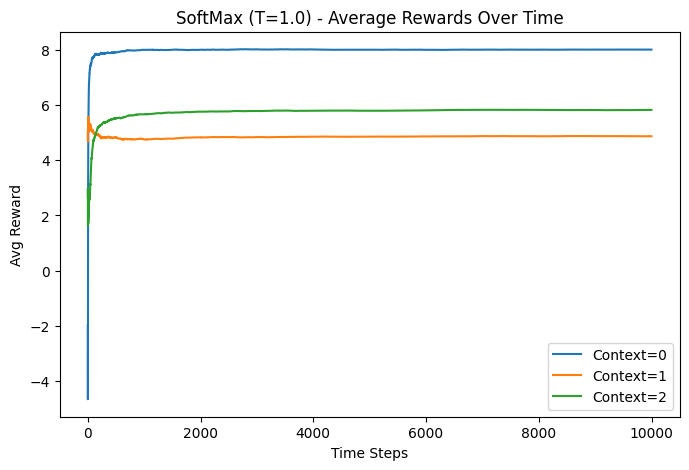


==== SoftMax (Hyperparam=2.0) - Actual Rewards ====
  Context=0: Average Actual Reward = 7.739 over 10000 steps.
  Context=1: Average Actual Reward = 4.339 over 10000 steps.
  Context=2: Average Actual Reward = 5.171 over 10000 steps.
  Overall average actual reward = 5.750


[Final Q-Values (Expected Rewards) for SoftMax, Hyperparam=2.0]
  Context=0:
    Arm=0 (Entertainment): Q = 1.004
    Arm=1 (Education): Q = 7.994
    Arm=2 (Tech): Q = -8.314
    Arm=3 (Crime): Q = -2.025
  Context=1:
    Arm=0 (Entertainment): Q = -6.834
    Arm=1 (Education): Q = 5.007
    Arm=2 (Tech): Q = 2.005
    Arm=3 (Crime): Q = -3.052
  Context=2:
    Arm=0 (Entertainment): Q = 3.009
    Arm=1 (Education): Q = 0.034
    Arm=2 (Tech): Q = -4.041
    Arm=3 (Crime): Q = 6.011



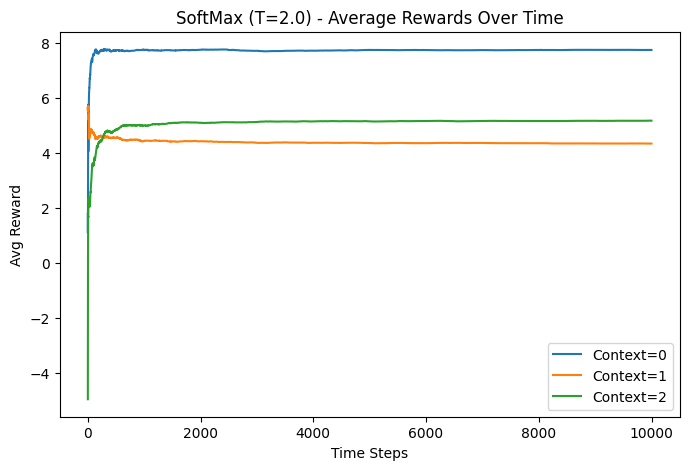

In [21]:

def print_expected_rewards(policy_name, hyperparam, Q_dict, contexts):
    
    cat_map = {0:'Entertainment',1:'Education',2:'Tech',3:'Crime'}
    print(f"\n[Final Q-Values (Expected Rewards) for {policy_name}, Hyperparam={hyperparam}]")
    for c in contexts:
        print(f"  Context={c}:")
        for arm_idx, q_val in enumerate(Q_dict[c]):
            category_name = cat_map.get(arm_idx, f"Arm{arm_idx}")
            print(f"    Arm={arm_idx} ({category_name}): Q = {q_val:.3f}")
    print()

def print_average_rewards(policy_name, hyperparam, actual_rewards_history, contexts):
    
    print(f"\n==== {policy_name} (Hyperparam={hyperparam}) - Actual Rewards ====")
    all_rewards = []
    for c in contexts:
        c_rewards = actual_rewards_history[c]
        avg_c = np.mean(c_rewards) if len(c_rewards) else 0
        print(f"  Context={c}: Average Actual Reward = {avg_c:.3f} over {len(c_rewards)} steps.")
        all_rewards.extend(c_rewards)
    overall_avg = np.mean(all_rewards) if len(all_rewards) else 0
    print(f"  Overall average actual reward = {overall_avg:.3f}\n")


epsilons   = [0.1, 0.5, 0.7]    # Epsilon-Greedy
C_values   = [1, 2, 3]          # UCB
temp_values= [0.5, 1.0, 2.0]    # SoftMax

print("\nCOMPARING MULTIPLE HYPERPARAMETERS WITH PRINTED EXPECTED REWARDS + PLOTS\n")

for eps in epsilons:
    # Train
    Q_e, rewards_e = train_epsilon_greedy(epsilon=eps, T=10000)
    # Print actual rewards
    print_average_rewards("Epsilon-Greedy", eps, rewards_e, contexts)
    # Print final Q-values (expected rewards)
    print_expected_rewards("Epsilon-Greedy", eps, Q_e, contexts)
    # Plot cumulative average reward
    plot_cumulative_rewards(rewards_e, contexts, f"Epsilon-Greedy (ε={eps})")



for c_val in C_values:
    # Train
    Q_u, rewards_u = train_ucb(C=c_val, T=10000)
    # Print actual rewards
    print_average_rewards("UCB", c_val, rewards_u, contexts)
    # Print final Q-values
    print_expected_rewards("UCB", c_val, Q_u, contexts)
    # Plot cumulative average
    plot_cumulative_rewards(rewards_u, contexts, f"UCB (C={c_val})")



for temp in temp_values:
    # Train
    Q_s, rewards_s = train_softmax(temperature=temp, T=10000)
    # Print actual rewards
    print_average_rewards("SoftMax", temp, rewards_s, contexts)
    # Print final Q-values
    print_expected_rewards("SoftMax", temp, Q_s, contexts)
    # Plot cumulative average
    plot_cumulative_rewards(rewards_s, contexts, f"SoftMax (T={temp})")

